In [1]:
%pip install -q numpy pandas matplotlib seaborn scikit-learn xgboost joblib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
# %%
import os
import json
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)
import joblib

# xgboost optional
try:
    from xgboost import XGBClassifier
    XGB_AVAILABLE = True
except Exception:
    XGB_AVAILABLE = False
    
os.makedirs("results_dir", exist_ok=True)


## 1. Load Datasets  

In [19]:
# Put your data files in a folder named `data/` relative to the notebook.
loan_path = "data/Loan_Default.csv"
loan_txt = "data/Loan.txt"
borrower_txt = "data/Borrower.txt"
loan_prod_txt = "data/Loan_prod.txt"
borrower_prod_txt = "data/Borrower_prod.txt"

loan_df = pd.read_csv(loan_path) if os.path.exists(loan_path) else pd.DataFrame()
loan_ms = pd.read_csv(loan_txt, sep='\t') if os.path.exists(loan_txt) else pd.DataFrame()
borrower_ms = pd.read_csv(borrower_txt, sep='\t') if os.path.exists(borrower_txt) else pd.DataFrame()
loan_prod_ms = pd.read_csv(loan_prod_txt, sep='\t') if os.path.exists(loan_prod_txt) else pd.DataFrame()
borrower_prod_ms = pd.read_csv(borrower_prod_txt, sep='\t') if os.path.exists(borrower_prod_txt) else pd.DataFrame()
print("Shapes -> loan_df:", loan_df.shape, "loan_ms:", loan_ms.shape, "borrower_ms:", borrower_ms.shape)

# If Microsoft files available, attempt safe merge with common columns; otherwise use loan_df only
if not loan_df.empty and not loan_ms.empty and not borrower_ms.empty:
    microsoft_df = pd.merge(loan_ms, borrower_ms, how='left', on='memberId')
    # choose intersection columns only (avoid misaligned concat)
    common_cols = list(set(loan_df.columns).intersection(set(microsoft_df.columns)))
    if len(common_cols) >= 6:
        print(f"Using {len(common_cols)} common columns to combine datasets.")
        data = pd.concat([loan_df[common_cols], microsoft_df[common_cols]], axis=0, ignore_index=True)
    else:
        print("Not enough overlap - using loan_df only.")
        data = loan_df.copy()
elif not loan_df.empty:
    data = loan_df.copy()
else:
    raise FileNotFoundError("No dataset found. Please place Loan_Default.csv (and optionally Loan.txt, Borrower.txt) in data/ folder.")

Shapes -> loan_df: (148670, 34) loan_ms: (100000, 11) borrower_ms: (100000, 17)
Not enough overlap - using loan_df only.


## 2. Basic Dataset Overview  

In [20]:
print("\n--- FIRST 5 RECORDS ---")
print(data.head())

print("\n--- LAST 5 RECORDS ---")
print(data.tail())

print("\n--- SHAPE OF DATA (ROWS, COLUMNS) ---")
print(data.shape)

print("\n--- COLUMN NAMES ---")
print(list(data.columns))

print("\n--- DATA TYPES ---")
print(data.dtypes)

print("\n--- STATISTICAL SUMMARY ---")
print(data.describe(include='all'))

print("\n--- DATAFRAME INFO ---")
print(data.info())



--- FIRST 5 RECORDS ---
      ID  year loan_limit             Gender approv_in_adv loan_type  \
0  24890  2019         cf  Sex Not Available         nopre     type1   
1  24891  2019         cf               Male         nopre     type2   
2  24892  2019         cf               Male           pre     type1   
3  24893  2019         cf               Male         nopre     type1   
4  24894  2019         cf              Joint           pre     type1   

  loan_purpose Credit_Worthiness open_credit business_or_commercial  ...  \
0           p1                l1        nopc                  nob/c  ...   
1           p1                l1        nopc                    b/c  ...   
2           p1                l1        nopc                  nob/c  ...   
3           p4                l1        nopc                  nob/c  ...   
4           p1                l1        nopc                  nob/c  ...   

   credit_type  Credit_Score  co-applicant_credit_type    age  \
0          EXP      

## 3. Handling Missing Values & Duplicates  

In [21]:
print("\nMissing values per column:\n", data.isnull().sum())

print("\nDuplicate rows before drop:", data.duplicated().sum())
data = data.drop_duplicates().reset_index(drop=True)
print("Duplicate rows after drop:", data.duplicated().sum())

# Impute missing values: numeric -> median, categorical -> mode
for col in data.columns:
    if data[col].isnull().any():
        if pd.api.types.is_numeric_dtype(data[col]):
            data[col].fillna(data[col].median(), inplace=True)
        else:
            mode_val = data[col].mode()
            data[col].fillna(mode_val.iloc[0] if not mode_val.empty else "", inplace=True)

print("\nMissing values handled.")



Missing values per column:
 ID                               0
year                             0
loan_limit                    3344
Gender                           0
approv_in_adv                  908
loan_type                        0
loan_purpose                   134
Credit_Worthiness                0
open_credit                      0
business_or_commercial           0
loan_amount                      0
rate_of_interest             36439
Interest_rate_spread         36639
Upfront_charges              39642
term                            41
Neg_ammortization              121
interest_only                    0
lump_sum_payment                 0
property_value               15098
construction_type                0
occupancy_type                   0
Secured_by                       0
total_units                      0
income                        9150
credit_type                      0
Credit_Score                     0
co-applicant_credit_type         0
age                       

## 4. Schema Definition & Data Type Conversion  

In [22]:
schema = {
    'loan_amount': 'float',
    'rate_of_interest': 'float',
    'term': 'category',
    'Credit_Score': 'float',
    'income': 'float',
    'loan_purpose': 'category',
    'Credit_Worthiness': 'category',
    'Gender': 'category',
    'Status': 'category',
    'age': 'float',
    'LTV': 'float',
    'dtir1': 'float'
}

for col, dtype in schema.items():
    if col in data.columns:
        try:
            if dtype == 'category':
                data[col] = data[col].astype('category')
            else:
                data[col] = pd.to_numeric(data[col], errors='coerce').astype(dtype)
        except Exception as e:
            print(f"Could not convert {col}: {e}")

print("Schema conversion attempted.")


Schema conversion attempted.


## 5. Exploratory Data Visualization  

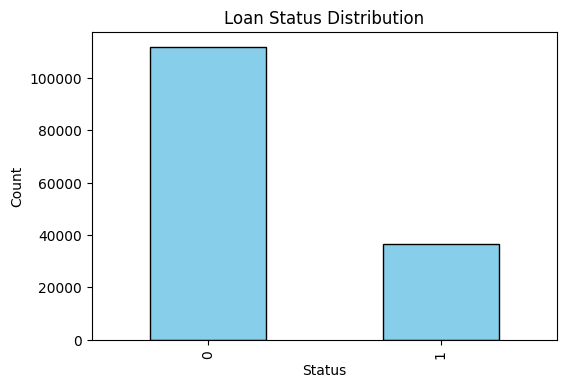

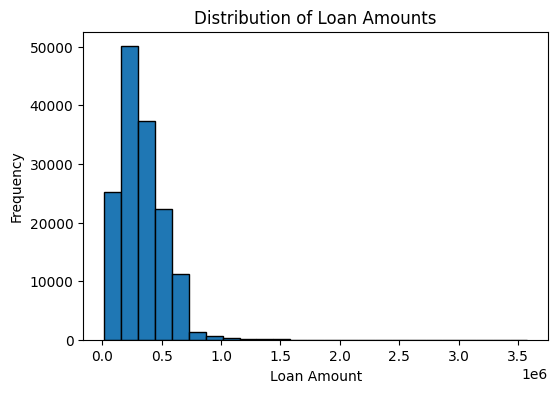

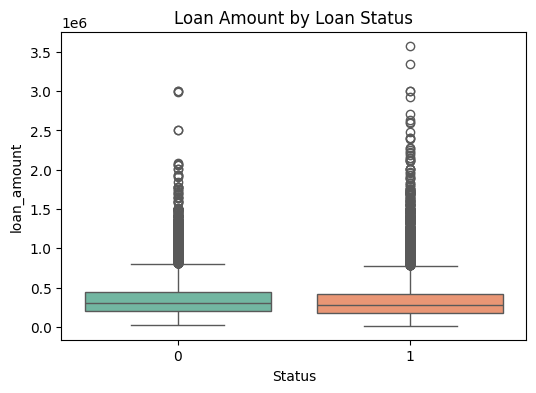


Numeric columns: ['ID', 'year', 'loan_amount', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'property_value', 'income', 'Credit_Score', 'age', 'LTV', 'dtir1']


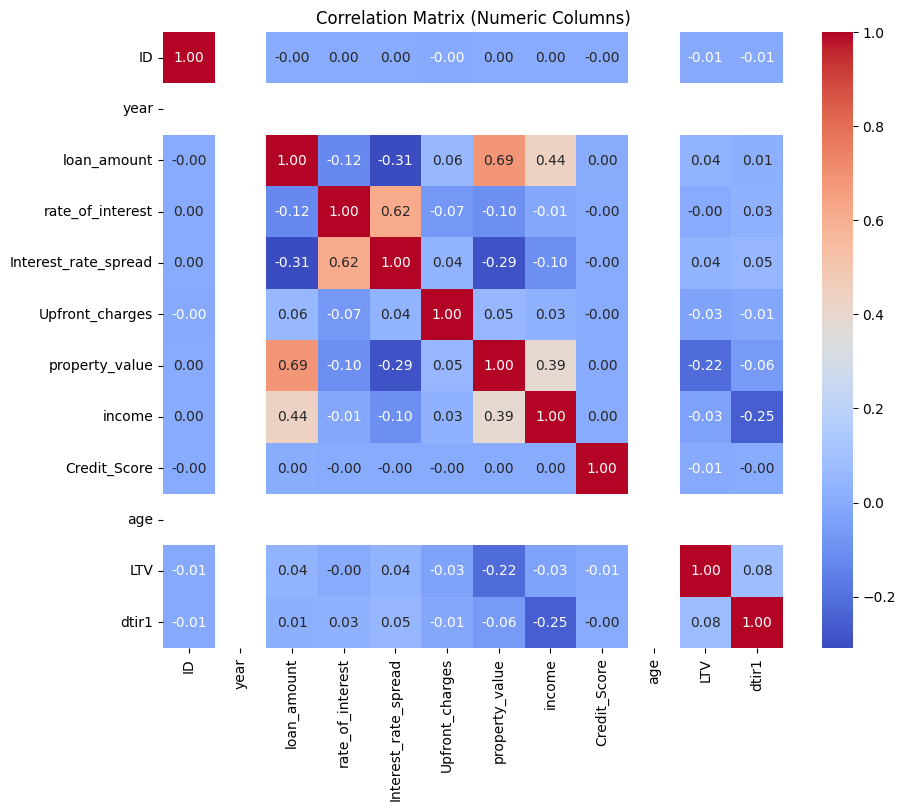

In [23]:
plt.figure(figsize=(6,4))
if 'Status' in data.columns:
    data['Status'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title('Loan Status Distribution'); plt.xlabel('Status'); plt.ylabel('Count'); plt.show()

plt.figure(figsize=(6,4))
if 'loan_amount' in data.columns:
    plt.hist(data['loan_amount'].dropna(), bins=25, edgecolor='black')
    plt.title('Distribution of Loan Amounts'); plt.xlabel('Loan Amount'); plt.ylabel('Frequency'); plt.show()

plt.figure(figsize=(6,4))
if set(['Status','loan_amount']).issubset(data.columns):
    sns.boxplot(x='Status', y='loan_amount', data=data, palette='Set2')
    plt.title('Loan Amount by Loan Status'); plt.show()

# Numeric correlation heatmap
numeric_columns = data.select_dtypes(include=[np.number])
print("\nNumeric columns:", list(numeric_columns.columns))
if not numeric_columns.empty:
    c = numeric_columns.corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(c, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title('Correlation Matrix (Numeric Columns)'); plt.show()


## 6. Preprocessing

In [24]:
# Ensure target exists
if 'Status' not in data.columns:
    raise KeyError('Target column "Status" not found in data.')

target_column = 'Status'
X = data.drop(columns=[target_column])
y = data[target_column]

# identify categorical and numeric columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
print("Categorical cols:", cat_cols)
print("Numeric cols:", num_cols)

# Fill tiny remaining NAs (safety)
for c in cat_cols:
    X[c] = X[c].fillna(X[c].mode().iloc[0])
for c in num_cols:
    X[c] = X[c].fillna(X[c].median())

# One-hot encoding
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
if cat_cols:
    encoder.fit(X[cat_cols])
    X_cat = pd.DataFrame(encoder.transform(X[cat_cols]), columns=encoder.get_feature_names_out(cat_cols))
else:
    X_cat = pd.DataFrame()

X_num = pd.DataFrame(X[num_cols].values, columns=num_cols)
X_final = pd.concat([X_num.reset_index(drop=True), X_cat.reset_index(drop=True)], axis=1)
print("Final feature matrix shape (before split):", X_final.shape)

# Train/test split
X_train_final, X_test_final, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42, stratify=y
)
print("X_train_final:", X_train_final.shape, "X_test_final:", X_test_final.shape)

# Scale numeric columns
scaler = StandardScaler()
if num_cols:
    X_train_final[num_cols] = scaler.fit_transform(X_train_final[num_cols])
    X_test_final[num_cols] = scaler.transform(X_test_final[num_cols])

# Save preprocessed files (optional)
X_train_final.to_csv("X_train_final.csv", index=False)
X_test_final.to_csv("X_test_final.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)
print("Preprocessing complete. Train and test sets saved.")

Categorical cols: ['loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose', 'Credit_Worthiness', 'open_credit', 'business_or_commercial', 'term', 'Neg_ammortization', 'interest_only', 'lump_sum_payment', 'construction_type', 'occupancy_type', 'Secured_by', 'total_units', 'credit_type', 'co-applicant_credit_type', 'submission_of_application', 'Region', 'Security_Type']
Numeric cols: ['ID', 'year', 'loan_amount', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'property_value', 'income', 'Credit_Score', 'age', 'LTV', 'dtir1']
Final feature matrix shape (before split): (148670, 90)
X_train_final: (118936, 90) X_test_final: (29734, 90)
Preprocessing complete. Train and test sets saved.


Feature Selection

In [26]:
# Choose feature selection method: 'kbest', 'rfe', 'from_rf', or None
from sklearn.feature_selection import RFE, SelectFromModel, mutual_info_classif


feature_method = 'from_rf'   # change to 'kbest', 'rfe', or None as needed
selector_obj = None

def select_kbest_fit(Xtr, ytr, Xte, k=40):
    k = min(k, Xtr.shape[1])
    sel = SelectKBest(mutual_info_classif   , k=k)
    sel.fit(Xtr, ytr)
    return sel.transform(Xtr), sel.transform(Xte), sel

def select_rfe_fit(Xtr, ytr, Xte, n=40):
    n = min(n, Xtr.shape[1])
    base = LogisticRegression(max_iter=2000)
    sel = RFE(base, n_features_to_select=n)
    sel.fit(Xtr, ytr)
    return sel.transform(Xtr), sel.transform(Xte), sel

def select_from_rf_fit(Xtr, ytr, Xte):
    rf = RandomForestClassifier(n_estimators=200, random_state=42)
    rf.fit(Xtr, ytr)
    sfm = SelectFromModel(rf, threshold='median', prefit=True)
    return sfm.transform(Xtr), sfm.transform(Xte), sfm

if feature_method == 'kbest':
    Xtr_sel, Xte_sel, selector_obj = select_kbest_fit(X_train_final, y_train, X_test_final, k=40)
elif feature_method == 'rfe':
    Xtr_sel, Xte_sel, selector_obj = select_rfe_fit(X_train_final, y_train, X_test_final, n=40)
elif feature_method == 'from_rf':
    Xtr_sel, Xte_sel, selector_obj = select_from_rf_fit(X_train_final, y_train, X_test_final)
else:
    # No selection: use full arrays
    Xtr_sel, Xte_sel = X_train_final.values, X_test_final.values
    selector_obj = None

print("Selected train shape:", np.array(Xtr_sel).shape)
print("Selected test shape:", np.array(Xte_sel).shape)


Selected train shape: (118936, 45)
Selected test shape: (29734, 45)


In [27]:
def get_metrics(y_true, y_pred, y_proba=None):
    cm = confusion_matrix(y_true, y_pred)
    if cm.shape == (2,2):
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan
    else:
        specificity = np.nan
    accuracy = accuracy_score(y_true, y_pred)
    sensitivity = recall_score(y_true, y_pred, zero_division=0)
    precision = precision_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_proba) if (y_proba is not None and len(np.unique(y_true))==2) else np.nan
    return accuracy, sensitivity, precision, specificity, f1, auc


In [28]:
trained_models = {}
model_results = []   # TRAIN metrics storage


## 7. Model Training & Evaluation (Multiple Models)  


Training: Logistic Regression


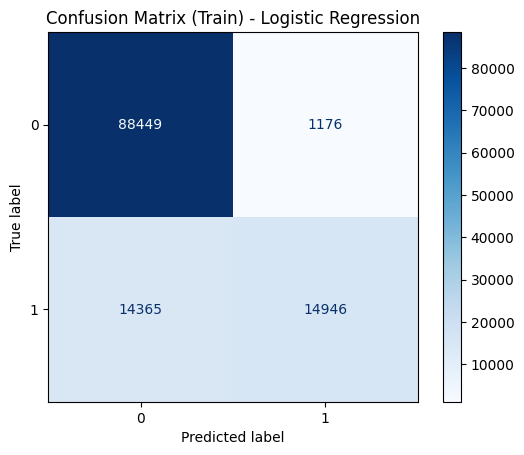

Train accuracy (Logistic Regression): 0.8693

Training: Naive Bayes


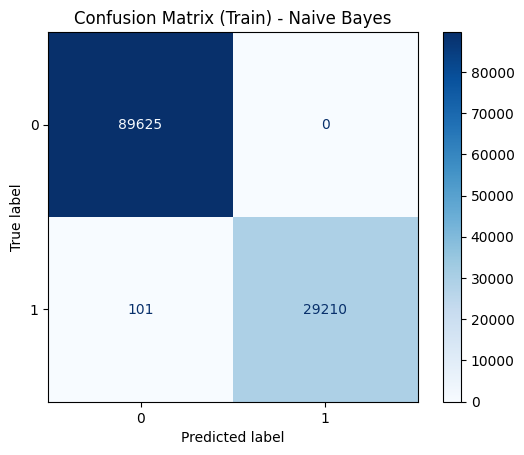

Train accuracy (Naive Bayes): 0.9992

Training: Decision Tree


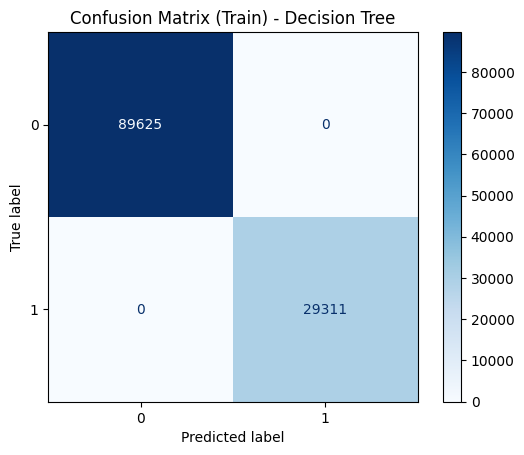

Train accuracy (Decision Tree): 1.0000

Training: Random Forest


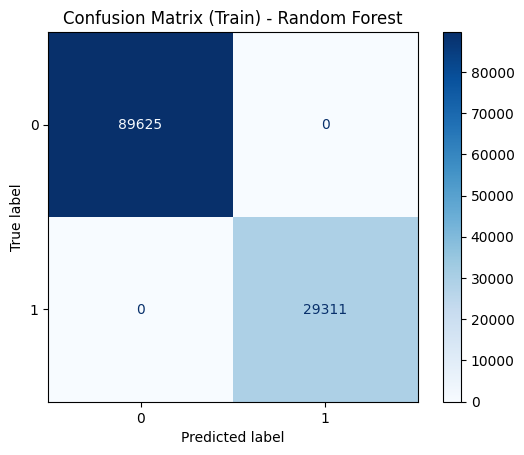

Train accuracy (Random Forest): 1.0000

Training: K-Nearest Neighbors


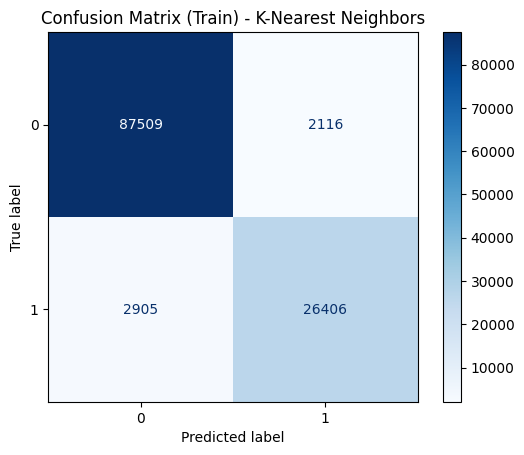

Train accuracy (K-Nearest Neighbors): 0.9578

Training: XGBoost


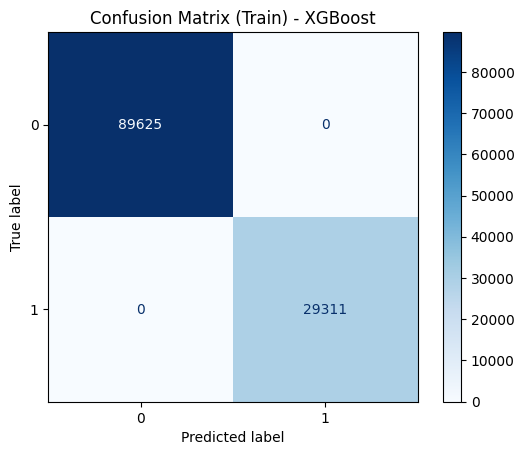

Train accuracy (XGBoost): 1.0000


In [29]:
models_to_train = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('Naive Bayes', GaussianNB()),
    ('Decision Tree', DecisionTreeClassifier(random_state=42)),
    ('Random Forest', RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')),
    ('K-Nearest Neighbors', KNeighborsClassifier(n_neighbors=5)),
    ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
    
]

for idx, (name, model) in enumerate(models_to_train, start=1):
    try:
        print("\nTraining:", name)
        model.fit(Xtr_sel, y_train)
        trained_models[name] = model

        # Train predictions & metrics
        y_tr_pred = model.predict(Xtr_sel)
        y_tr_proba = model.predict_proba(Xtr_sel)[:,1] if hasattr(model, 'predict_proba') else None
        acc, sens, prec, spec, f1, auc = get_metrics(y_train, y_tr_pred, y_tr_proba)
        model_results.append([idx, name, acc, sens, prec, spec, f1, auc])

        # Confusion matrix
        ConfusionMatrixDisplay.from_estimator(model, Xtr_sel, y_train, cmap='Blues', values_format='d')
        plt.title(f"Confusion Matrix (Train) - {name}")
        plt.show()
        print(f"Train accuracy ({name}): {acc:.4f}")

    except Exception as e:
        print("Error training", name, ":", e)



Training MLP activation = relu


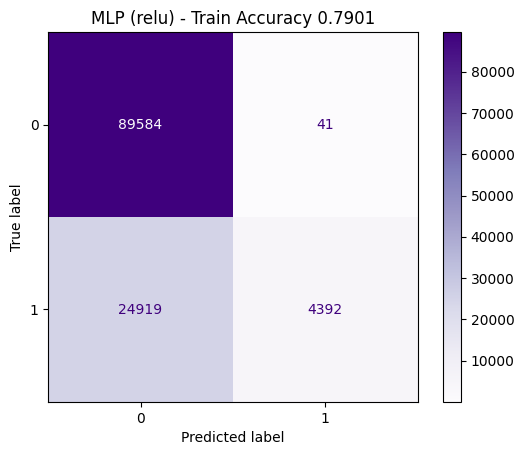

MLP (relu) Train Acc: 0.7901

Training MLP activation = tanh


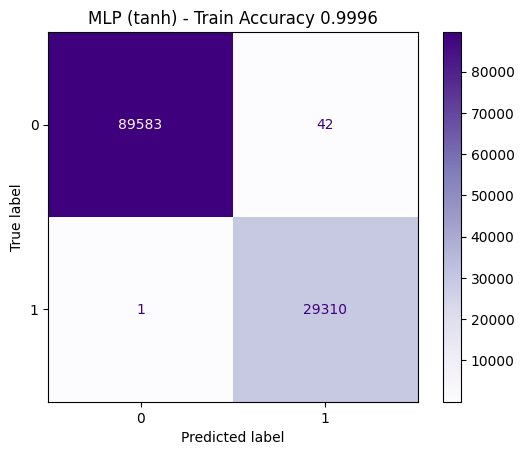

MLP (tanh) Train Acc: 0.9996

Training MLP activation = logistic


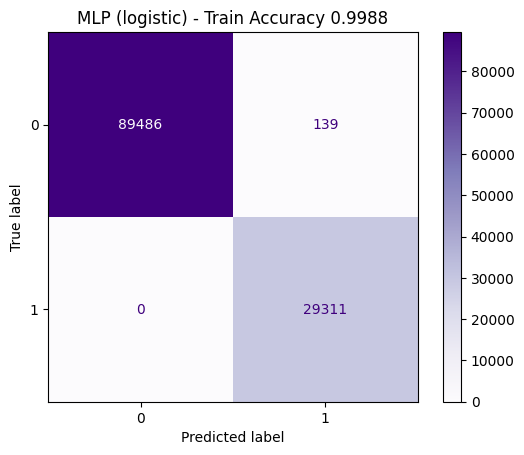

MLP (logistic) Train Acc: 0.9988


In [30]:
mlp_results = []
activations = ['relu', 'tanh', 'logistic']

for act in activations:
    print("\nTraining MLP activation =", act)
    mlp = MLPClassifier(hidden_layer_sizes=(100,), activation=act, max_iter=400, random_state=42)
    try:
        mlp.fit(Xtr_sel, y_train)
        trained_models[f"MLP_{act}"] = mlp

        y_tr_pred = mlp.predict(Xtr_sel)
        y_tr_proba = mlp.predict_proba(Xtr_sel)[:,1] if hasattr(mlp, 'predict_proba') else None
        acc, sens, prec, spec, f1, auc = get_metrics(y_train, y_tr_pred, y_tr_proba)
        mlp_results.append(['MLP_'+act, acc, sens, prec, spec, f1, auc])

        ConfusionMatrixDisplay.from_estimator(mlp, Xtr_sel, y_train, cmap='Purples', values_format='d')
        plt.title(f"MLP ({act}) - Train Accuracy {acc:.4f}")
        plt.show()
        print(f"MLP ({act}) Train Acc: {acc:.4f}")
    except Exception as e:
        print("Failed MLP", act, ":", e)


In [31]:
train_columns = ["S.No","Model","Accuracy","Sensitivity","Precision","Specificity","F1-Score","AUC"]
train_df = pd.DataFrame(model_results, columns=train_columns)
print("\n--- TRAINING PERFORMANCE SUMMARY ---")
print(train_df)
train_df.to_csv("model_training_summary.csv", index=False)
print("Saved model_training_summary.csv")



--- TRAINING PERFORMANCE SUMMARY ---
   S.No                Model  Accuracy  Sensitivity  Precision  Specificity  \
0     1  Logistic Regression  0.869333     0.509911   0.927056     0.986879   
1     2          Naive Bayes  0.999151     0.996554   1.000000     1.000000   
2     3        Decision Tree  1.000000     1.000000   1.000000     1.000000   
3     4        Random Forest  1.000000     1.000000   1.000000     1.000000   
4     5  K-Nearest Neighbors  0.957784     0.900890   0.925812     0.976391   
5     6              XGBoost  1.000000     1.000000   1.000000     1.000000   

   F1-Score       AUC  
0  0.657936  0.859563  
1  0.998274  0.999983  
2  1.000000  1.000000  
3  1.000000  1.000000  
4  0.913181  0.991145  
5  1.000000  1.000000  
Saved model_training_summary.csv


Evaluation

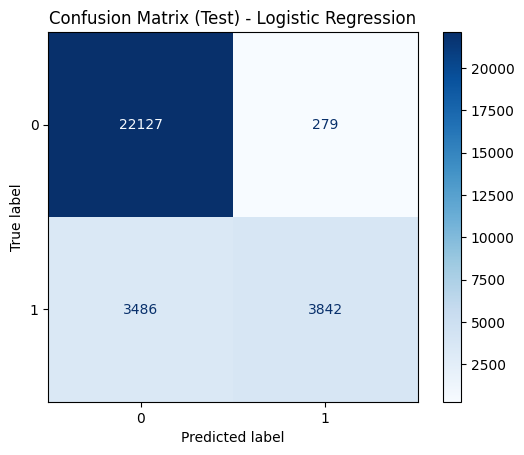

Test accuracy for Logistic Regression: 0.8734


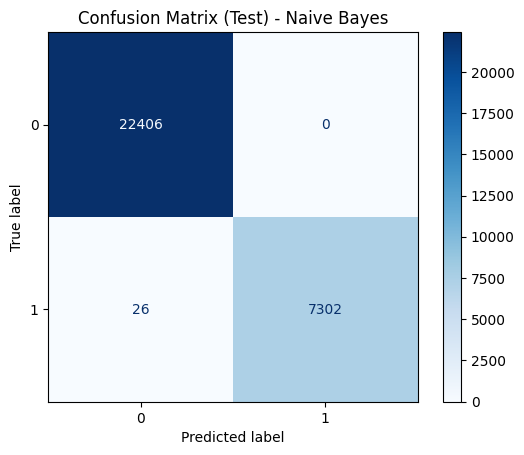

Test accuracy for Naive Bayes: 0.9991


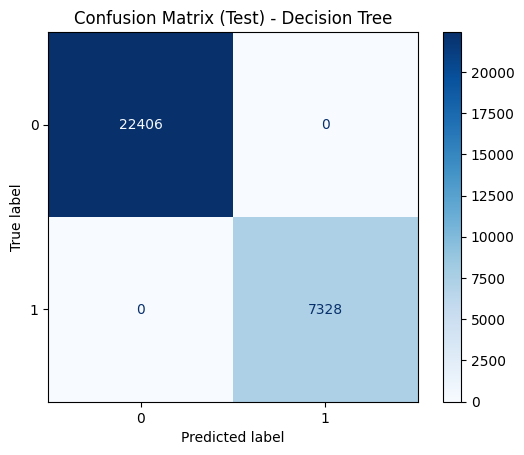

Test accuracy for Decision Tree: 1.0000


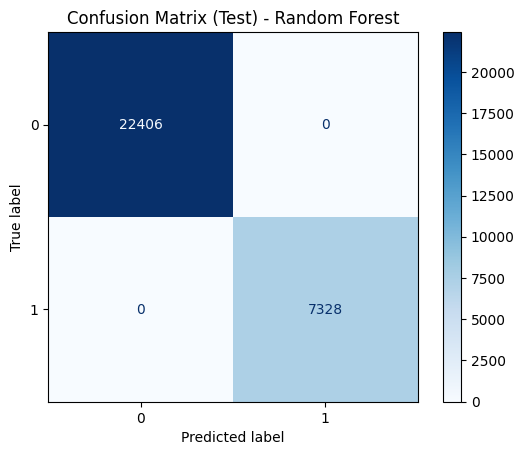

Test accuracy for Random Forest: 1.0000


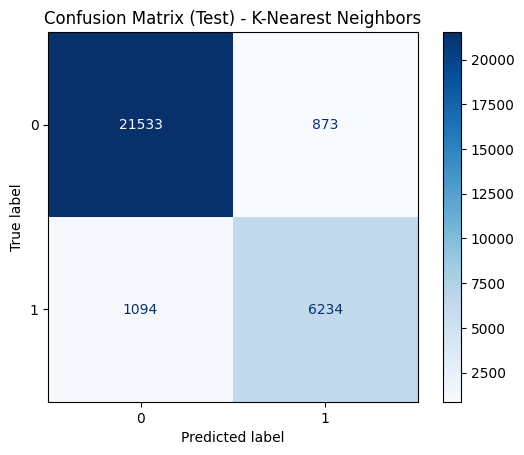

Test accuracy for K-Nearest Neighbors: 0.9338


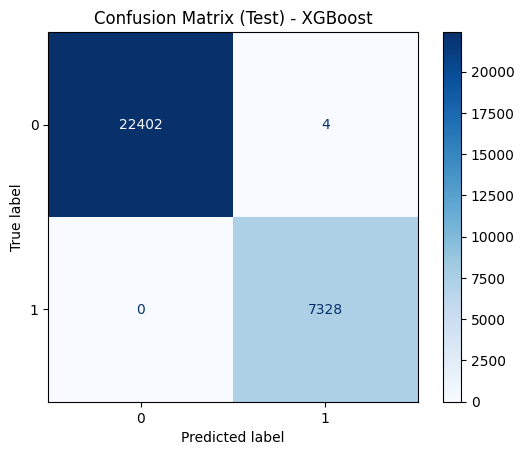

Test accuracy for XGBoost: 0.9999


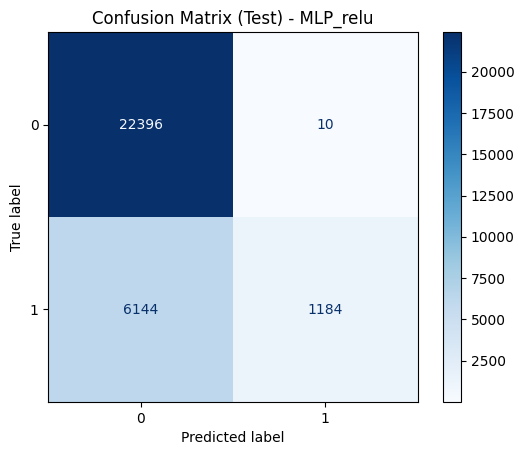

Test accuracy for MLP_relu: 0.7930


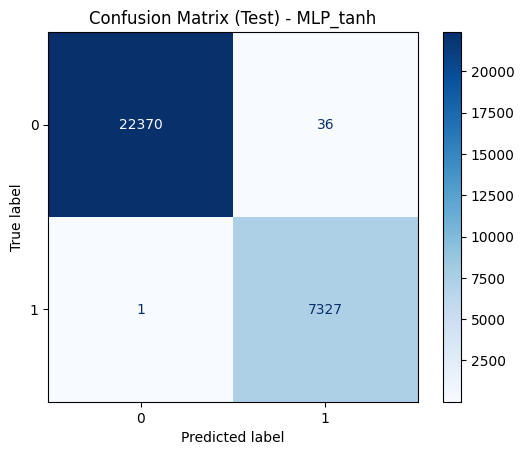

Test accuracy for MLP_tanh: 0.9988


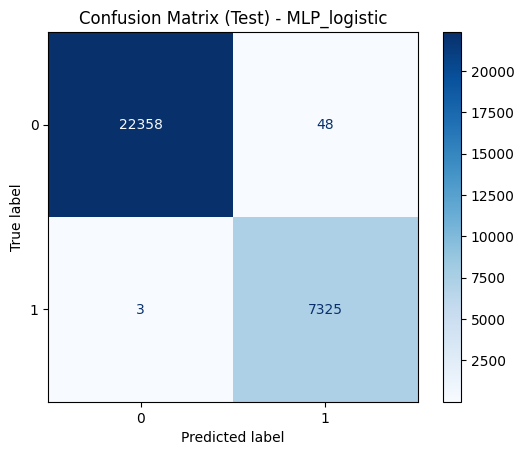

Test accuracy for MLP_logistic: 0.9983

--- TESTING PERFORMANCE SUMMARY ---
   S.No                Model  Accuracy  Sensitivity  Precision  Specificity  \
0     1  Logistic Regression  0.873377     0.524290   0.932298     0.987548   
1     2          Naive Bayes  0.999126     0.996452   1.000000     1.000000   
2     3        Decision Tree  1.000000     1.000000   1.000000     1.000000   
3     4        Random Forest  1.000000     1.000000   1.000000     1.000000   
4     5  K-Nearest Neighbors  0.933847     0.850710   0.877163     0.961037   
5     6              XGBoost  0.999865     1.000000   0.999454     0.999821   
6     7             MLP_relu  0.793032     0.161572   0.991625     0.999554   
7     8             MLP_tanh  0.998756     0.999864   0.995111     0.998393   
8     9         MLP_logistic  0.998285     0.999591   0.993490     0.997858   

   F1-Score       AUC  
0  0.671150  0.863532  
1  0.998223  1.000000  
2  1.000000  1.000000  
3  1.000000  1.000000  
4  0.863734  

In [32]:
testing_results = []
for i, (name, model) in enumerate(trained_models.items(), start=1):
    try:
        y_te_pred = model.predict(Xte_sel)
        y_te_proba = model.predict_proba(Xte_sel)[:,1] if hasattr(model, 'predict_proba') else None
        acc, sens, prec, spec, f1, auc = get_metrics(y_test, y_te_pred, y_te_proba)
        testing_results.append([i, name, acc, sens, prec, spec, f1, auc])

        ConfusionMatrixDisplay.from_estimator(model, Xte_sel, y_test, cmap='Blues', values_format='d')
        plt.title(f"Confusion Matrix (Test) - {name}")
        plt.show()
        print(f"Test accuracy for {name}: {acc:.4f}")

    except Exception as e:
        print("Error evaluating", name, ":", e)

test_df = pd.DataFrame(testing_results, columns=train_columns)
print("\n--- TESTING PERFORMANCE SUMMARY ---")
print(test_df)
test_df.to_csv("model_testing_summary.csv", index=False)
print("Saved model_testing_summary.csv")


In [33]:
# Merge train and test results on Model name (handle duplicates)
# Ensure 'Model' is string and unique enough for merge
train_merge = train_df.copy(); train_merge['Model'] = train_merge['Model'].astype(str)
test_merge = test_df.copy(); test_merge['Model'] = test_merge['Model'].astype(str)

final_comparison = pd.merge(train_merge, test_merge, on='Model', suffixes=('_Train','_Test'))
print("\n--- FINAL COMBINED TRAIN & TEST ---")
print(final_comparison)
final_comparison.to_csv("final_model_comparison.csv", index=False)
print("Saved final_model_comparison.csv")



--- FINAL COMBINED TRAIN & TEST ---
   S.No_Train                Model  Accuracy_Train  Sensitivity_Train  \
0           1  Logistic Regression        0.869333           0.509911   
1           2          Naive Bayes        0.999151           0.996554   
2           3        Decision Tree        1.000000           1.000000   
3           4        Random Forest        1.000000           1.000000   
4           5  K-Nearest Neighbors        0.957784           0.900890   
5           6              XGBoost        1.000000           1.000000   

   Precision_Train  Specificity_Train  F1-Score_Train  AUC_Train  S.No_Test  \
0         0.927056           0.986879        0.657936   0.859563          1   
1         1.000000           1.000000        0.998274   0.999983          2   
2         1.000000           1.000000        1.000000   1.000000          3   
3         1.000000           1.000000        1.000000   1.000000          4   
4         0.925812           0.976391        0.913181   

Top 10 features


Top 10 features by importance:
Upfront_charges              0.259074
Interest_rate_spread         0.250311
rate_of_interest             0.168608
credit_type_EQUI             0.116654
LTV                          0.035101
property_value               0.029999
dtir1                        0.019008
income                       0.012377
lump_sum_payment_lpsm        0.007002
Neg_ammortization_neg_amm    0.006354
dtype: float64


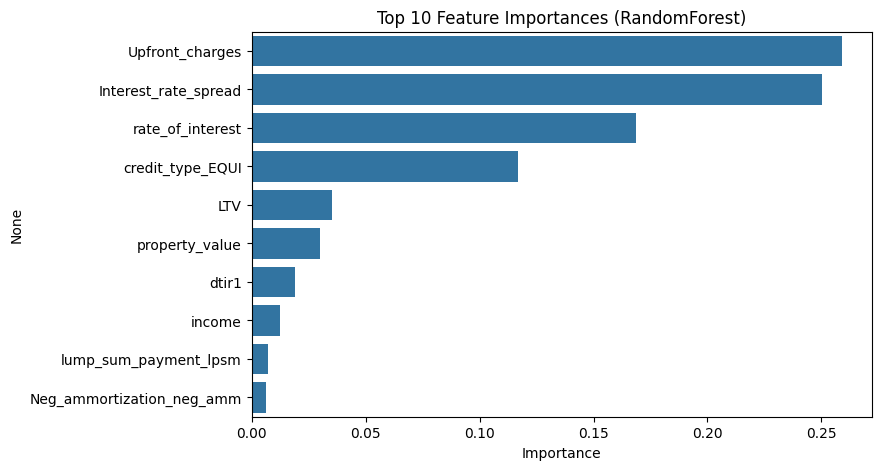

In [34]:
try:
    rf_for_importance = RandomForestClassifier(n_estimators=200, random_state=42)
    rf_for_importance.fit(X_train_final, y_train)
    if hasattr(rf_for_importance, 'feature_importances_'):
        feat_imp = pd.Series(rf_for_importance.feature_importances_, index=X_train_final.columns)
        top10 = feat_imp.sort_values(ascending=False).head(10)
        print("\nTop 10 features by importance:")
        print(top10)
        plt.figure(figsize=(8,5))
        sns.barplot(x=top10.values, y=top10.index)
        plt.title('Top 10 Feature Importances (RandomForest)')
        plt.xlabel('Importance')
        plt.show()
except Exception as e:
    print("Could not compute feature importances:", e)


compare model

<Figure size 1200x600 with 0 Axes>

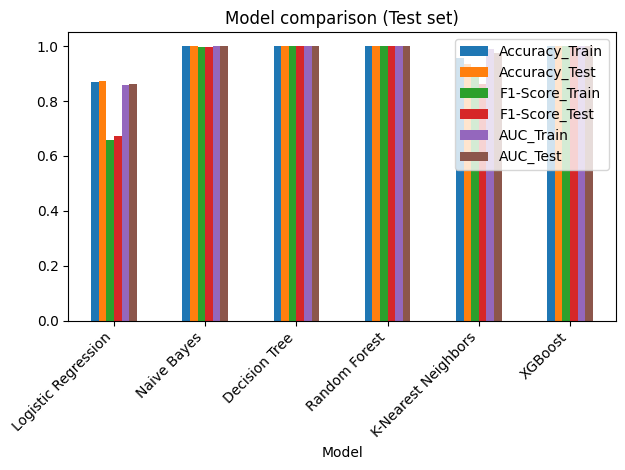

In [41]:
# %%
# Comparison plot (Accuracy, F1, AUC)
cmp = final_comparison.set_index("Model")[["Accuracy_Train", "Accuracy_Test", "F1-Score_Train", "F1-Score_Test", "AUC_Train", "AUC_Test"]].fillna(0)
plt.figure(figsize=(12,6))
cmp.plot(kind="bar")
plt.title("Model comparison (Test set)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join( "model_comparison_test.png"), dpi=150)
plt.show()


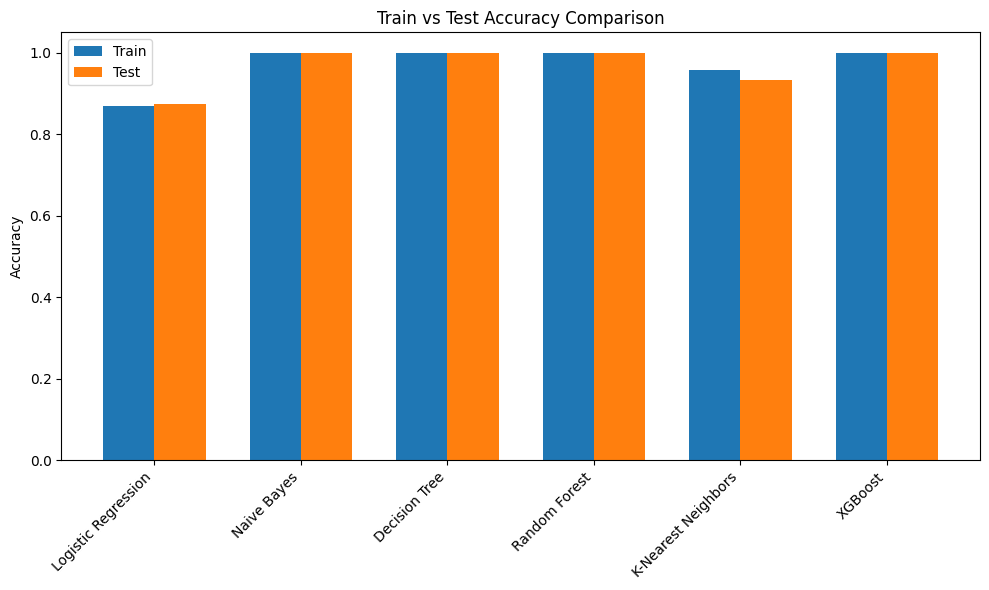

In [35]:
try:
    df_plot = final_comparison.copy()
    plt.figure(figsize=(10,6))
    x = np.arange(len(df_plot))
    width = 0.35
    plt.bar(x - width/2, df_plot['Accuracy_Train'], width, label='Train')
    plt.bar(x + width/2, df_plot['Accuracy_Test'], width, label='Test')
    plt.xticks(x, df_plot['Model'], rotation=45, ha='right')
    plt.ylabel('Accuracy')
    plt.title('Train vs Test Accuracy Comparison')
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Could not plot comparison:", e)


Mathematical eq

In [38]:
print("Logistic regression: z = w^T x + b; probability = sigmoid(z) = 1/(1+exp(-z))")
if 'Logistic Regression' in trained_models:
    lr = trained_models['Logistic Regression']
    try:
        coefs = lr.coef_.flatten()
        # if selector used and has get_support use that to map to feature names
        if selector_obj is not None:
            try:
                # for SelectFromModel or SelectKBest/RFE there are ways to retrieve names; try safe fallback
                if hasattr(selector_obj, "get_support"):
                    mask = selector_obj.get_support()
                    feature_names = np.array(X_train_final.columns)[mask]
                elif hasattr(selector_obj, "get_feature_names_out"):
                    feature_names = selector_obj.get_feature_names_out()
                else:
                    feature_names = list(range(len(coefs)))
            except:
                feature_names = list(range(len(coefs)))
        else:
            feature_names = X_train_final.columns
        coef_ser = pd.Series(coefs, index=feature_names)
        print("\nTop logistic magnitude coefficients:")
        print(coef_ser.abs().sort_values(ascending=False).head(10))
    except Exception as e:
        print("Could not show logistic coefficients:", e)

print("\nSVM (linear): f(x) = w^T x + b; margin ~ 2/||w||")

print("\nRandomForest: ensemble of trees; feature importances reflect splits")


Logistic regression: z = w^T x + b; probability = sigmoid(z) = 1/(1+exp(-z))

Top logistic magnitude coefficients:
credit_type_EQUI                     7.336731
credit_type_EXP                      2.272751
credit_type_CIB                      2.233950
credit_type_CRIF                     2.195158
lump_sum_payment_lpsm                1.574990
term_300.0                           1.040618
loan_purpose_p4                      1.017918
submission_of_application_to_inst    0.988378
loan_purpose_p1                      0.984916
lump_sum_payment_not_lpsm            0.940118
dtype: float64

SVM (linear): f(x) = w^T x + b; margin ~ 2/||w||

RandomForest: ensemble of trees; feature importances reflect splits


best model

In [40]:
try:
    # pick best by test accuracy if available; otherwise pick best train
    if not test_df.empty:
        best_idx = test_df['Accuracy'].idxmax()
        best_name = test_df.loc[best_idx, 'Model']
    else:
        best_name = train_df.loc[train_df['Accuracy'].idxmax(), 'Model']

    best_model = trained_models.get(best_name, None)

    # ---------- SAFE FEATURE NAME EXTRACTION ----------
    if selector_obj is None:
        feature_list = list(X_train_final.columns)

    elif hasattr(selector_obj, "get_support"):
        mask = selector_obj.get_support()
        feature_list = list(X_train_final.columns[mask])

    else:
        feature_list = list(X_train_final.columns)

    # ---------- SAVE FINAL PURVI MODEL ----------
    payload = {
        'encoder': encoder,
        'scaler': scaler,
        'selector': selector_obj,
        'model': best_model,
        'feature_list': feature_list
    }

    joblib.dump(payload, "PurviModel.joblib")
    print("Saved PurviModel.joblib with best model:", best_name)

except Exception as e:
    print("Could not save PurviModel:", e)


Saved PurviModel.joblib with best model: Decision Tree
